In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from detectshift.utils import *
from detectshift.exp_utils import *
from detectshift.tests import *
from detectshift.cd_models import *

%config InlineBackend.figure_format = 'retina'

####### Fixing Seed #######
random_seed=42
np.random.seed(random_seed)
###########################

In [2]:
X=np.load('data/X_cifar10.npy')
y=np.load('data/y_cifar10.npy')

In [3]:
X=X[:30000]
y=y[:30000]

In [4]:
ds=[.4,.3,.2,.1]

Xs_dic, ys_dic, Xt_dic, yt_dic = {},{},{},{}

for d in ds:

  K=np.unique(y).shape[0]
  prop=np.linspace(d,1-d,K)
  Xt,yt,Xs,ys = np.zeros(shape=(0,X.shape[1])), np.zeros(shape=(0,y.shape[1])), np.zeros(shape=(0,X.shape[1])), np.zeros(shape=(0,y.shape[1]))

  shuffle = np.random.choice(range(X.shape[0]), size=(X.shape[0],), replace=False)
  X=X[shuffle]
  y=y[shuffle]
    
  for k in range(K):
    ind=(y==k).squeeze()
    nk=np.sum(ind)
    m=int(prop[k]*nk)
    Xs=np.vstack((Xs, X[ind][:m]))
    ys=np.vstack((ys, y[ind][:m]))
    Xt=np.vstack((Xt, X[ind][m:]))
    yt=np.vstack((yt, y[ind][m:]))

  print(d)
  Xs_dic[d], ys_dic[d], Xt_dic[d], yt_dic[d] = Xs, ys, Xt, yt

0.4
0.3
0.2
0.1


In [5]:
pvals=[]
kls=[]
covshift_models=[]
task='class'
test=.1
B=250

for d in tqdm(ds):

    ### Setting-up data
    Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
    Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs_dic[d], ys_dic[d].squeeze(), Xt_dic[d], yt_dic[d].squeeze(), test=test, task=task, random_state=random_seed)
    
    ### Training models
    totshift_model = KL(boost=False, cv=None)
    totshift_model.fit(Zs_train, Zt_train)
    covshift_models.append(KL(boost=False, cv=None))
    covshift_models[-1].fit(Xs_train, Xt_train)
    
    cd_model = cde_class(boost=False, cv=None)
    cd_model.fit(pd.concat([Xs_train, Xt_train], axis=0), 
                 pd.concat([ys_train, yt_train], axis=0))
 
    
    ### Getting test statistics and p-vals
    out = ShiftDiagnostics(Xs_test, ys_test, Xt_test, yt_test,
                           totshift_model=totshift_model, covshift_model=covshift_models[-1], labshift_model=None,
                           cd_model=cd_model, task=task, B=B, verbose=False)
    
    ### Output
    pvals.append([d, out['lab']['pval'], out['cov']['pval'], out['conc1']['pval'], out['conc2']['pval'], out['tot']['pval']])
    kls.append([d, out['lab']['kl'], out['cov']['kl'], out['conc1']['kl'], out['conc2']['kl'], out['tot']['kl']])


100%|██████████| 4/4 [12:10<00:00, 182.58s/it]


In [6]:
kls=np.array(kls)
pvals=np.array(pvals)

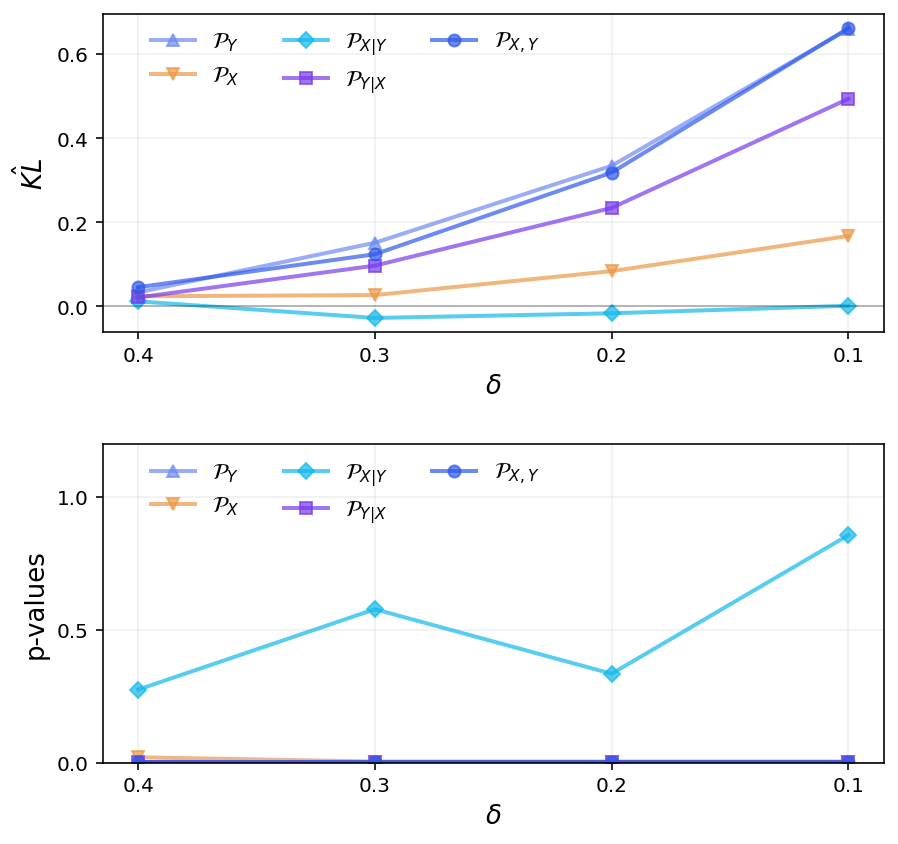

In [8]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.35   # the amount of height reserved for white space between subplots
    
plt.figure(figsize=(7,6.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.subplot(2, 1, 1)
exp_plots([str(d) for d in ds], kls, xlab="$\delta$", ylab="$\hat{KL}$", grid='both')

plt.subplot(2, 1, 2)
exp_plots([str(d) for d in ds], pvals, xlab="$\delta$", ylab="p-values", grid='both')
plt.ylim(0,1.2)

plt.savefig('plots/cifar10.png', bbox_inches='tight', dpi=300, transparent=True)